In [1]:
import pyscf
import numpy as np
import matplotlib.pyplot as plt
import scipy
from pyscf.scf import RHF
from numpy.linalg import norm
from numpy.linalg import inv

In [2]:
CO=pyscf.gto.M(atom='C 0 0 0; O 0 0 1.1',basis='def2-TZVP')
NN=pyscf.gto.M(atom='N 0 0 0; N 0 0 1.1',basis='def2-TZVP')

In [3]:
nnhf=RHF(NN)
nnhf.scf()
Pn=nnhf.make_rdm1()
O=nnhf.mo_occ
On=np.diag(O)
Sn=nnhf.get_ovlp()

converged SCF energy = -108.9876382454


In [4]:
# P=COC+
# PSP = CO(C+SC)OC+ = C O O C+  , but O is RHF (2*id)
# PSP=P  becomes for RHF -> PSP /2 =P

np.allclose(np.dot(Pn,np.dot(Sn,Pn))/2,Pn)

True

In [5]:
cohf=RHF(CO)
cohf.scf()
Pc=cohf.make_rdm1()
O=cohf.mo_occ
Oc=np.diag(O)
Sc=cohf.get_ovlp()

converged SCF energy = -112.787127600436


In [6]:
np.allclose(np.dot(Pc,np.dot(Sc,Pc))/2,Pc)

True

#########################<br>Now trying to do CO-> NN   <br>#########################

In [7]:
print(np.einsum('ij,ji',Sc,Pn))
print(np.einsum('ij,ji',Sn,Pc))

13.951665611023314
13.986996269518606


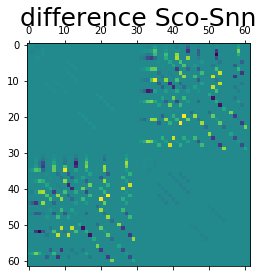

norm= 1.5449998317421108


In [8]:
plt.matshow(Sc-Sn)
plt.title('difference Sco-Snn',size=25)
plt.show()
print ('norm=',norm(Sc-Sn))

False
0.1407663567878327


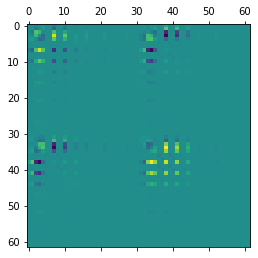

In [9]:
print(np.allclose(np.dot(Pc,np.dot(Sn,Pc))/2,Pc))
plt.matshow(np.dot(Pc,np.dot(Sn,Pc))/2-Pc)
#print(np.dot(Pc,np.dot(Sn,Pc))/2-Pc)
print(norm(np.dot(Pc,np.dot(Sn,Pc))/2-Pc))

False
0.14109424471686646
13.99999999999999


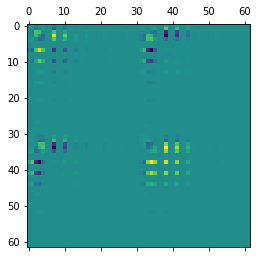

In [10]:
Pc2=Pc*14/np.einsum('ij,ji',Sn,Pc)

print(np.allclose(np.dot(Pc2,np.dot(Sn,Pc2))/2,Pc2))
plt.matshow(np.dot(Pc2,np.dot(Sn,Pc2))/2-Pc2)
#print(np.dot(Pc,np.dot(Sn,Pc))/2-Pc)
print(norm(np.dot(Pc2,np.dot(Sn,Pc2))/2-Pc2))
print(np.einsum('ij,ji',Sn,Pc2))

Do it iteratively, P_n+1 = P_n S P_n   and pray

14.034232629677179
0.2825741061971762


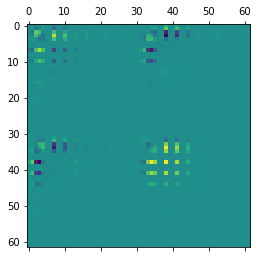

In [11]:
Pc3=np.dot(Pc2,np.dot(Sn,Pc2))/2
print(np.einsum('ij,ji',Sn,Pc3))
Pc3=Pc3*14/np.einsum('ij,ji',Sn,Pc3)
plt.matshow(np.dot(Pc3,np.dot(Sn,Pc3))/2-Pc3)
print(norm(np.dot(Pc3,np.dot(Sn,Pc3))/2-Pc3))

try: 
$$ P+\Delta P = (P+\Delta P)S_N(P+\Delta P)/2$$
At the first order in $\Delta P$
$$(P-PS_NP)/2 + \Delta P = PS_N \Delta P$$
$$ \Delta P = (1-PS_N)^{-1} (PS_NP-P) /2 $$


4.0441990995445915e-16


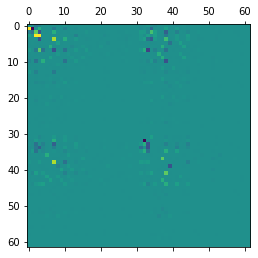

In [40]:
Pc2=Pc
for i in range(100):
    Pc2=Pc2*14/np.einsum('ij,ji',Sn,Pc2)
    dP=inv(np.eye(62)-Pc2.dot(Sn)).dot(Pc2.dot(Sn.dot(Pc2))/2-Pc2)/2
    Pc2=Pc2+dP

Pc3=Pc2
Pc3=Pc3*14/np.einsum('ij,ji',Sn,Pc3)
plt.matshow(np.dot(Pc3,np.dot(Sn,Pc3))/2-Pc3)
print(norm(np.dot(Pc3,np.dot(Sn,Pc3))/2-Pc3))

In [41]:
dm=Pc2
h1=nnhf.get_hcore()
S=nnhf.get_ovlp()

num_e=np.einsum('ij,ji',S,dm)
print ('difference in num_electrons=',num_e)
dm*=14/num_e
h2=nnhf.get_veff(dm=dm)
mee=np.einsum('ij,ji',h1,dm)
bee=np.einsum('ij,ji',h2,dm)/2
print ('monoelettronic enegy = ',mee)
print ('Bielettronic enegy = ',bee)

print('Total energy = ', nnhf.kernel(),mee+bee+nnhf.energy_nuc())

difference in num_electrons= 14.0
monoelettronic enegy =  -194.54300500249792
Bielettronic enegy =  62.3416421537736
converged SCF energy = -108.9876382454
Total energy =  -108.98763824539954 -108.62892345319706
